In [1]:
!pip install -q segmentation_models_pytorch
# pip install -qU wandb
!pip install -q scikit-learn==1.0

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⚙️ Configuration 

In [4]:
class CFG:
    seed          = 101
    exp_name      = 'UNet-Scratch2'
    comment       = 'unet-efficientnet_b1-224x224-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'Nil'
    train_bs      = 16
    valid_bs      = 16 #train_bs*2
    img_size      = [224, 224]
    epochs        = 15
    lr            = 2e-4
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-7
    wd            = 1e-7
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# ❗ Reproducibility

In [5]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


# 📖 Meta Data

* Files
    * train.csv - IDs and masks for all training objects.
    * sample_submission.csv - a sample submission file in the correct format
    * train - a folder of case/day folders, each containing slice images for a particular case on a given day.

> Note that the image filenames include 4 numbers (ex. `276_276_1.63_1.63.png`). These four numbers are slice height / width (integers in pixels) and heigh/width pixel spacing (floating points in mm). The first two defines the resolution of the slide. The last two record the physical size of each pixel.

* Columns
    * id - unique identifier for object
    * class - the predicted class for the object
    * EncodedPixels - RLE-encoded pixels for the identified object

In [6]:
BASE_PATH  = '/kaggle/input/uw-madison-gi-tract-image-segmentation'

In [7]:
df = pd.read_csv('../input/uwmgi-mask-dataset/train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['mask_path'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')
df = df.sample(n=10000, random_state=1)
df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case102_day0_slice_0120,102,0,120,/kaggle/input/uw-madison-gi-tract-image-segmen...,310,360,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,[],0,True
1,case44_day0_slice_0029,44,0,29,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,[],0,True
2,case89_day0_slice_0099,89,0,99,/kaggle/input/uw-madison-gi-tract-image-segmen...,310,360,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,[34079 3 34438 5 34797 7 35156 9 35516 9 35876...,1098,False
3,case115_day0_slice_0121,115,0,121,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,[],0,True
4,case74_day18_slice_0141,74,18,141,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,[],0,True


In [8]:
df.to_csv('train_sampled_data.csv')

## Class Distribution

In [9]:
df['empty'].value_counts().plot.bar()

# 🔨 Utility

## Mask

In [10]:
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

## Image

In [11]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk
    

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

## RLE

In [12]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 📁 Create Folds

In [13]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False     621
      True     1352
1.0   False     451
      True     1031
2.0   False     646
      True     1433
3.0   False     494
      True     1107
4.0   False     587
      True     1417
Name: id, dtype: int64

# 🍚 Dataset

In [14]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

# 🌈 Augmentations

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
#         A.OneOf([
#             A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# # #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
#             A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
#         ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# 🍰 DataLoader

In [16]:
def prepare_loaders(fold):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [17]:
train_loader, valid_loader = prepare_loaders(fold=0)

In [18]:
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([16, 3, 224, 224]), torch.Size([16, 3, 224, 224]))

# 📈 Visualization

In [19]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

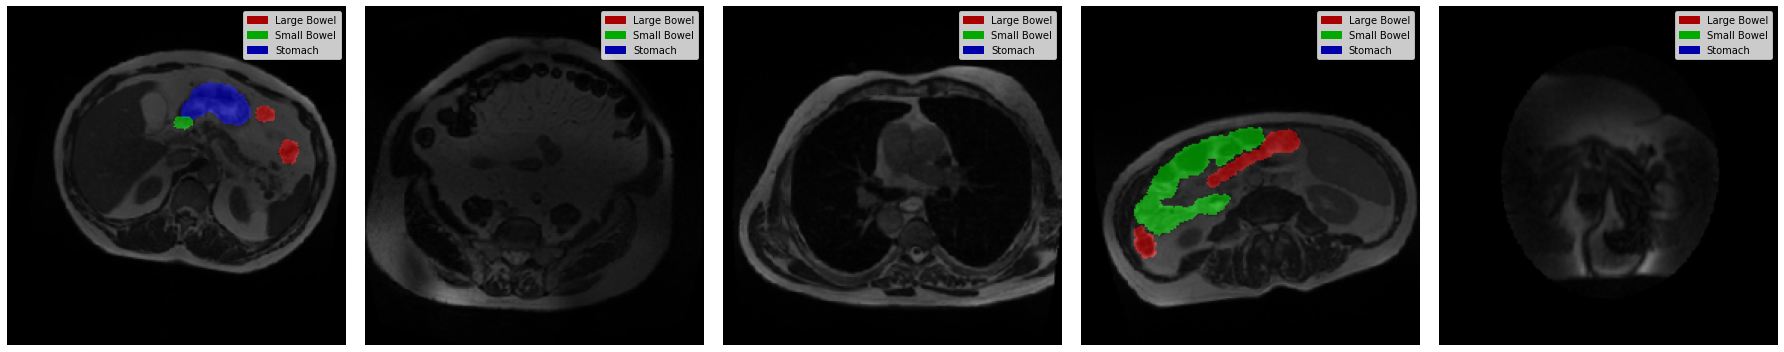

In [20]:
plot_batch(imgs, msks, size=5)

In [21]:
import gc
gc.collect()

18085

# 📦 Model


In [22]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)


class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=3, features =[64, 128, 256, 512]):
    super(UNet, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #down part of UNet
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    #upsample part of UNet
    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride = 2
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size = 1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size = skip_connection.shape[2:])
        
      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

In [23]:
def test():
  x = torch.randn((3,1,224,224))
  model = UNet(in_channels = 1, out_channels = 1)
  preds = model(x)
  print(x.shape)
  print(preds.shape)

test()

torch.Size([3, 1, 224, 224])
torch.Size([3, 1, 224, 224])


# 🔧 Loss Function

In [24]:
#JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
# LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
    TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

# 🚄 Training Function

In [25]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

# 👀 Validation Function

In [26]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_iou = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_iou])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# 🏃 Run Training

In [27]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
#     wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch)
        val_dice, val_iou = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid IOU'].append(val_iou)
        
        # Log the metrics
#         wandb.log({"Train Loss": train_loss, 
#                    "Valid Loss": val_loss,
#                    "Valid Dice": val_dice,
#                    "Valid IOU": val_iou,
#                    "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid IOU: {val_iou:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_iou = val_iou
            best_epoch   = epoch
        # run.summary["Best Dice"]    = best_dice
        # run.summary["Best IOU"] = best_iou
        # run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
#             wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_iou))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# 🔍 Optimizer

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" width=500>

In [28]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=100, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [29]:
model = UNet(in_channels = 3, out_channels = 3)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = fetch_scheduler(optimizer)

# 🚅 Training

In [30]:
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
#     run = wandb.init(project='uw-maddison-gi-tract', 
#                      config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
#                      anonymous=anonymous,
#                      name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
#                      group=CFG.comment,
#                     )
    train_loader, valid_loader = prepare_loaders(fold=fold) #, debug=CFG.debug)
    model     = UNet(in_channels = 3, out_channels = 3)
    model.to(CFG.device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
#     run.finish()
#     display(ipd.IFrame(run.url, width=1000, height=720))

###############
### Fold: 0
###############
cuda: Tesla T4

Epoch 1/15

Valid : 100%|██████████| 124/124 [00:47<00:00,  2.58it/s, gpu_memory=2.38 GB, lr=0.00017, valid_loss=0.6437]


Valid Dice: 0.5674 | Valid IOU: 0.5578
Valid Score Improved (-inf ---> 0.5674)
Model Saved


Epoch 2/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.57it/s, gpu_memory=2.49 GB, lr=0.00011, valid_loss=0.5864]


Valid Dice: 0.5278 | Valid IOU: 0.4978


Epoch 3/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.58it/s, gpu_memory=2.64 GB, lr=0.00004, valid_loss=0.5446]


Valid Dice: 0.6259 | Valid IOU: 0.5962
Valid Score Improved (0.5674 ---> 0.6259)
Model Saved


Epoch 4/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.57it/s, gpu_memory=2.64 GB, lr=0.00000, valid_loss=0.5066]


Valid Dice: 0.6398 | Valid IOU: 0.5990
Valid Score Improved (0.6259 ---> 0.6398)
Model Saved


Epoch 5/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.57it/s, gpu_memory=2.53 GB, lr=0.00002, valid_loss=0.4653]


Valid Dice: 0.6660 | Valid IOU: 0.6253
Valid Score Improved (0.6398 ---> 0.6660)
Model Saved


Epoch 6/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.58it/s, gpu_memory=2.66 GB, lr=0.00008, valid_loss=0.4125]


Valid Dice: 0.7292 | Valid IOU: 0.6885
Valid Score Improved (0.6660 ---> 0.7292)
Model Saved


Epoch 7/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.57it/s, gpu_memory=2.74 GB, lr=0.00015, valid_loss=0.3564]


Valid Dice: 0.6913 | Valid IOU: 0.6517


Epoch 8/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.58it/s, gpu_memory=2.78 GB, lr=0.00020, valid_loss=0.2996]


Valid Dice: 0.7510 | Valid IOU: 0.7125
Valid Score Improved (0.7292 ---> 0.7510)
Model Saved


Epoch 9/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.57it/s, gpu_memory=2.57 GB, lr=0.00019, valid_loss=0.2431]


Valid Dice: 0.7994 | Valid IOU: 0.7633
Valid Score Improved (0.7510 ---> 0.7994)
Model Saved


Epoch 10/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.58it/s, gpu_memory=2.62 GB, lr=0.00013, valid_loss=0.2093]


Valid Dice: 0.8165 | Valid IOU: 0.7801
Valid Score Improved (0.7994 ---> 0.8165)
Model Saved


Epoch 11/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.56it/s, gpu_memory=2.76 GB, lr=0.00006, valid_loss=0.1882]


Valid Dice: 0.8421 | Valid IOU: 0.8094
Valid Score Improved (0.8165 ---> 0.8421)
Model Saved


Epoch 12/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.57it/s, gpu_memory=2.52 GB, lr=0.00001, valid_loss=0.1752]


Valid Dice: 0.8367 | Valid IOU: 0.8035


Epoch 13/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.57it/s, gpu_memory=2.62 GB, lr=0.00001, valid_loss=0.1666]


Valid Dice: 0.8402 | Valid IOU: 0.8068


Epoch 14/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.57it/s, gpu_memory=2.78 GB, lr=0.00006, valid_loss=0.1609]


Valid Dice: 0.8558 | Valid IOU: 0.8229
Valid Score Improved (0.8421 ---> 0.8558)
Model Saved


Epoch 15/15

Valid : 100%|██████████| 124/124 [00:48<00:00,  2.58it/s, gpu_memory=2.71 GB, lr=0.00013, valid_loss=0.1548]


Valid Dice: 0.8618 | Valid IOU: 0.8282
Valid Score Improved (0.8558 ---> 0.8618)
Model Saved


Training complete in 0h 51m 48s
Best Score: 0.8282


In [31]:
print(history)

defaultdict(<class 'list'>, {'Train Loss': [0.3474842869483523, 0.3077368342423951, 0.2831932648978951, 0.2612029493204415, 0.24180769884583006, 0.21559333681078752, 0.1835588617819566, 0.14785973851636838, 0.11705051160394364, 0.10158974024592715, 0.08860086481222852, 0.08535083486253311, 0.07848046978396508, 0.07764978265790609, 0.07305935869669734], 'Valid Loss': [0.6437410941235135, 0.5864124741278743, 0.5446499393968732, 0.5065748632044823, 0.46529611599245957, 0.4124835160892746, 0.3564370780412884, 0.29963469395042974, 0.24311182942114926, 0.20931080179322026, 0.18824000948888062, 0.17520573194475267, 0.16658540787548204, 0.16090983372923692, 0.15477354769409457], 'Valid Dice': [0.56743824, 0.5278407, 0.6258897, 0.63980836, 0.6659848, 0.72921664, 0.69132364, 0.750956, 0.79937476, 0.8164817, 0.84207416, 0.8367204, 0.8401502, 0.85578626, 0.86176986], 'Valid IOU': [0.557789, 0.49779508, 0.5961604, 0.5990141, 0.62529236, 0.68846405, 0.65166754, 0.7125203, 0.7633201, 0.78007585, 0.80

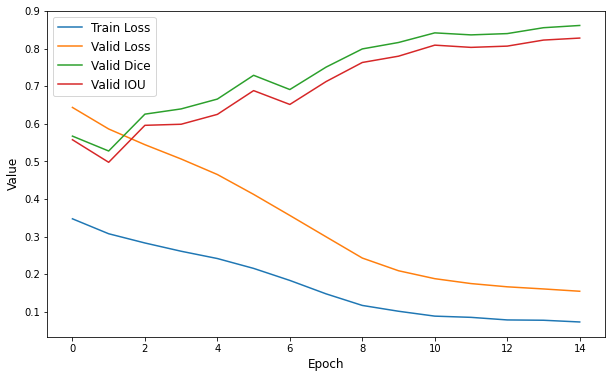

In [32]:
# Extract the keys and values from the history dictionary
keys = list(history.keys())
values = list(history.values())

# Set figure size
plt.figure(figsize=(10, 6))

# Plot the values for each key
for i, key in enumerate(keys):
    plt.plot(values[i], label=key)

# Add labels and a legend with larger font size
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)

# Increase tick font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

# 🔭 Prediction

In [33]:
test_dataset = BuildDataset(df.query("fold==0 & empty==0").sample(frac=1.0), label=False, 
                            transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=5, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
for fold in range(1):
    with torch.no_grad():
        pred = model(imgs)
        pred = (nn.Sigmoid()(pred)>0.5).double()
    preds.append(pred)
    
imgs  = imgs.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

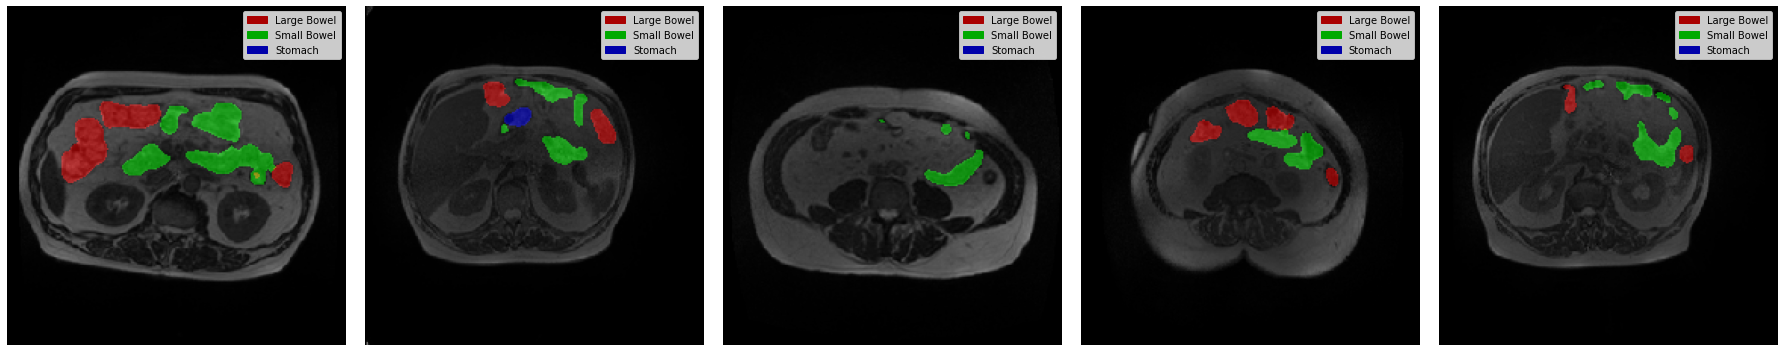

In [37]:
plot_batch(imgs, preds, size=5)

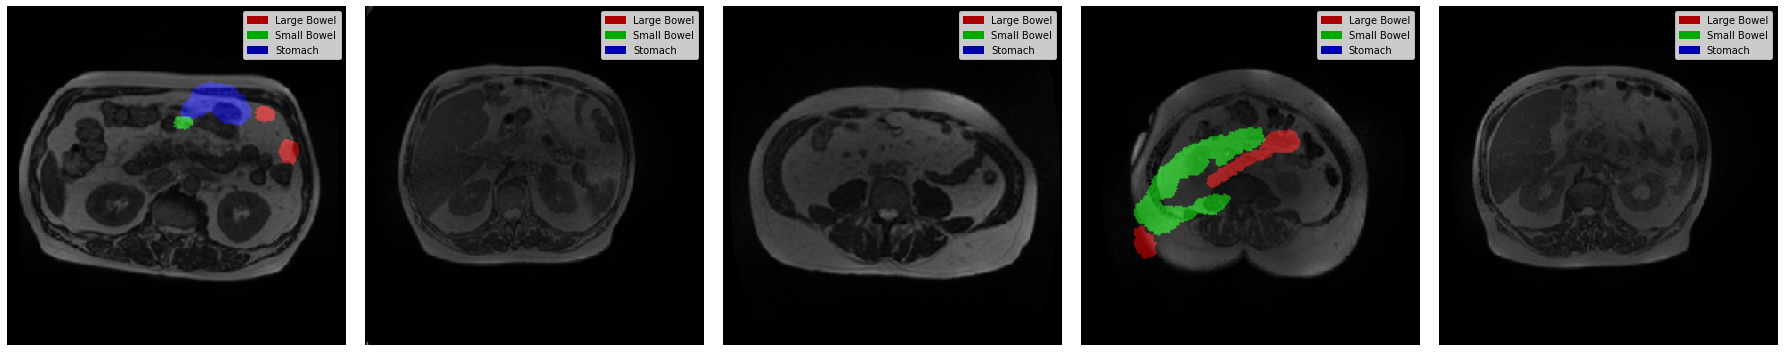

In [35]:
plot_batch(imgs, msks, size=5)

In [36]:
torch.save(model.state_dict(), '15_epoch.pt')